In [1]:
# import PyPDF2
# import spacy
import numpy as np
import pandas as pd
import fitz
import nltk

from nltk.tokenize import sent_tokenize
# from pathlib import Path

import os

# nlp = spacy.load('en_core_web_lg')

In [2]:
# sent_list = []

# for page in pdf_text[2:]:
#     doc = nlp(page)
#     for sentence in doc.sents:
#         sent_list.append(sentence)

In [3]:
path_pdf = 'C:\\Users\\tnguyen10\\OneDrive - Deloitte (O365D)\\Documents\\GitHub\\Thesis\\data\\reports'
fname_out = 'C:\\Users\\tnguyen10\\OneDrive - Deloitte (O365D)\\Documents\\GitHub\\Thesis\\data_structured\\report_sentences.csv'

In [4]:
def get_cnt(text):
    cnt = 0
    for word in text.split():
        if word.isalnum():
            cnt += 1
    return cnt

In [5]:
def get_text(block_lst):

    MIN_WORD_CNT = 6
    
    text_lst = []
    for block in block_lst:
        if block[6] != 0: continue # block_type: 0 = text
        
        #I'm replacing the non-ascii single quotation mark here, because it's used in Coca Cola's report
        text = block[4].replace('’',"'")
        text = ''.join([i if ord(i) < 128 else ' ' for i in text])
        #text = text.replace('fi ', 'fi') # PyMuPDF(fitz) bug fix: 'fi ' --> 'fi'
    
        if get_cnt(text) < MIN_WORD_CNT: continue # Delete sentences with less than MIN_WORD_CNT(10) 
    
        text_lst.append(text.replace('-\n', ''))
        #.replace('-\n', '')
    return ('\n'.join(text_lst))

In [6]:
# test_sent = sent_tokenize(text)[2]

# r_sent = ' '.join(test_sent.split()) #split splits the words of the sentence into a list - and gets rid of /n etc.

# ' '.join(test_sent.split()) #joins the items of the list with a space 

In [7]:
def get_sentence(fname):
 
    doc = fitz.open(fname)
    
    sent_lst = []
    for page_no, page in enumerate(doc):
        
        block_lst = page.get_text_blocks()
        text = get_text(block_lst)
    
        for i, sentence in enumerate(sent_tokenize(text)):
            r_sent = ' '.join(sentence.split()) # Delete '\n', '\t' and strip
            sent_lst.append(r_sent)
            
    doc.close()

    return sent_lst

In [8]:
def gen_document(fname, sent_lst):

    res_df = pd.DataFrame(
        {
            'doc_type': 'report',
            'company': fname.split('.')[0],
            'sentence': sent_lst
        }
    )
    
    return res_df

In [9]:
def read_filelist(path):

    # Create empty DataFrame
    df = pd.DataFrame()
    
    # Read file list (directory)
    for idx, fname in enumerate(os.listdir(path)):
        p_fname = os.path.join(path, fname)
        print('path + fname >>>', p_fname)
        
        if p_fname.split('.')[-1] != 'pdf': continue
        print('fname >>>',fname)
    
#         doc_id = int(idx)
        
#         print(f'doc_id = [{doc_id}], fname = [{fname}]')
#         print('')
    
        sent_lst = get_sentence(p_fname)
        df_doc   = gen_document(fname, sent_lst)
        
        df = pd.concat([df,df_doc])
        
    return df

In [10]:
%%time
df = read_filelist(path_pdf)
print('==== End of jobs ====')

path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\abb.pdf
fname >>> abb.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\adidas.pdf
fname >>> adidas.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\airbus.pdf
fname >>> airbus.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\apple.pdf
fname >>> apple.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\bayer.pdf
fname >>> bayer.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\beiersdorf.pdf
fname >>> beiersdorf.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\Documents\GitHub\Thesis\data\reports\blackrock.pdf
fname >>> blackrock.pdf
path + fname >>> C:\Users\tnguyen10\OneDrive - Deloitte (O365D)\D

In [11]:
df['sentence'].values[1507]

'In addition, many other smaller suppliers have also made these commitments.'

In [21]:
df.to_csv(fname_out, index = False)

In [14]:
df.values[0]

array(['report', 'abb',
       "One year into ABB's 2030 sustainability strategy, we are off to an excellent start in the pursuit of our ambitious targets."],
      dtype=object)

In [15]:
df['sentence'].values[6]

"We also joined the SBTi's Business Ambition for 1.5 C, an urgent call to action from a global coalition of United Nations agencies and business and industry leaders, in partnership with the Race to Zero campaign."

In [16]:
df.shape

(33553, 3)

There are 33553 sentences across 63 reports. This means that on average a report has 504 sentences. Divided by the average of 20 sentences per article, this gives us 26 articles on average per company are necessary to match the amount of sentences found in their reports.

# Further cleaning

In [17]:
df_report = df

In [18]:
df_report["sentence"] = df_report["sentence"].replace(r'http\S+|\[.\]:|www\S+|\w+/\S+|\w+-\w+-\S+|\[|\]','',regex = True).replace(r'^\s+|\s+$','',regex=True).replace(r'\s{2,}',' ',regex=True)
# original: http\S+|\[.\]:?|www\S+|\w+/\S+|\w+-\w+-\S+
#remove double spaces with one space and remove most hyperlinks + remove whitespaces at the end and beginning of a sentence

In [19]:
df_report['sentence'] = df_report['sentence'].str.replace('Nestl ', 'Nestle ')

In [20]:
df_report["word count"] = [len(i) for i in df_report["sentence"].str.split()]

In [21]:
df_report = df_report[df_report["word count"] > 5]

In [22]:
df_report = df_report[df_report["word count"] < 100]

array([[<Axes: title={'center': 'word count'}>]], dtype=object)

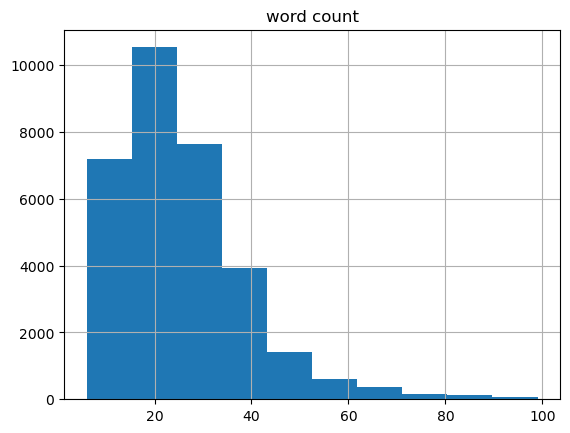

In [23]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
df_report.hist(column = 'word count')

In [24]:
df_report

,doc_type,company,sentence,word count
0,report,abb,One year into ABB's 2030 sustainability strate...,21
1,report,abb,"Compared with our baseline year of 2019, we ha...",27
2,report,abb,"Last year, we recorded no work-related fatalit...",13
3,report,abb,We also increased the number of women in senio...,39
4,report,abb,"Alongside these headline achievements, we made...",26
...,...,...,...,...
190,report,walmart,LABS works with engineering companies to devel...,20
191,report,walmart,Factories develop supervised corrective action...,18
192,report,walmart,LABS has been active in India and Vietnam sinc...,14
193,report,walmart,The program expanded to Cambodia in May 2022 a...,17


In [25]:
df_report.to_csv(fname_out, index = False)